# Personalizing a loss function with Tensorflow

In [1]:
import tensorflow as tf

tf.__version__

'2.15.0'

## Huber loss

Like any other loss function, it describes the error between our target value Y and the prediction we got from our neural network h(x).

$$ {\displaystyle L_{\delta }(y,h(x))={\begin{cases}{\frac {1}{2}}(y-h(x))^{2} \hspace{1.5cm} {\textrm {for}}|y-h(x)|\leq \delta ,\\\delta \,|y-h(x)|-{\frac {1}{2}}\delta ^{2} \hspace{5mm} {\textrm {otherwise.}}\end{cases}}}$$

Más información: https://en.wikipedia.org/wiki/Huber_loss

In [2]:
def create_huber(threshold=1.0): # This function implements the huber loss
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [4]:
huber_fn = create_huber(1.0) # the most common threshold value

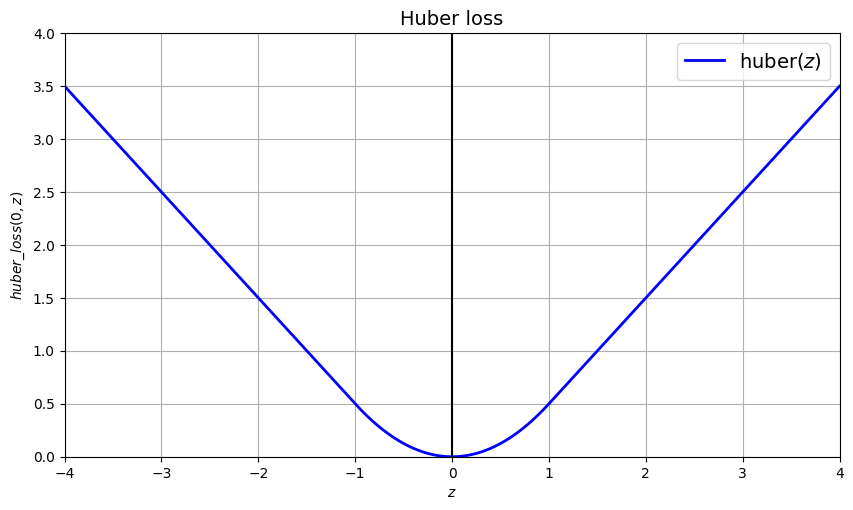

In [5]:
# Graphical representation of hubber loss

from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5.5))

z = np.linspace(-4, 4, 200)

plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)") # our target is 0

plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.ylabel("$huber\_loss(0, z)$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

# we can see that when z is 0, the error is also 0 because the predicted value = our target

## Training and ANN with the new loss function

We will use the Boston Housing dataset.

### Importing and visualizing dataset

In [6]:
from tensorflow.keras import datasets

In [7]:
boston_housing = datasets.boston_housing

In [8]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [9]:
import pandas as pd

features = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

df_train = pd.DataFrame(np.column_stack([X_train, y_train]), columns=features)
df_train.head(10)

# MEDV is our target variable (the medium house price)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
5,0.28392,0.0,7.38,0.0,0.493,5.708,74.3,4.7211,5.0,287.0,19.6,391.13,11.74,18.5
6,9.18702,0.0,18.10,0.0,0.700,5.536,100.0,1.5804,24.0,666.0,20.2,396.90,23.60,11.3
7,4.09740,0.0,19.58,0.0,0.871,5.468,100.0,1.4118,5.0,403.0,14.7,396.90,26.42,15.6
8,2.15505,0.0,19.58,0.0,0.871,5.628,100.0,1.5166,5.0,403.0,14.7,169.27,16.65,15.6
9,1.62864,0.0,21.89,0.0,0.624,5.019,100.0,1.4394,4.0,437.0,21.2,396.90,34.41,14.4


### Dataset division

In [10]:
from sklearn.model_selection import train_test_split

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

### Scaling

In [11]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_prep = scaler.fit_transform(X_train)
X_val_prep = scaler.transform(X_val)
X_test_prep = scaler.transform(X_test)

### Arquitecture of the ANN

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [13]:
network = models.Sequential()

network.add(layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]))
network.add(layers.Dense(10, activation='relu'))
network.add(layers.Dense(1))

In [14]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                420       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 741 (2.89 KB)
Trainable params: 741 (2.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### ANN training

First we will train using the loss function **_mean_squared_error_** to compare afterwards with the personalized loss function created before.

In [15]:
network.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae']
               )

In [16]:
history = network.fit(X_train_prep,
                      y_train,
                      epochs=50,
                      validation_data=(X_val_prep, y_val))

Epoch 1/50
13/13 [==============================] - 1s 18ms/step - loss: 553.5825 - mae: 21.3806 - val_loss: 651.3606 - val_mae: 23.4942
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 533.9716 - mae: 20.7945 - val_loss: 630.1257 - val_mae: 23.0283
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 514.1401 - mae: 20.2438 - val_loss: 609.1103 - val_mae: 22.6108
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 494.8684 - mae: 19.8019 - val_loss: 585.9167 - val_mae: 22.1631
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 473.9850 - mae: 19.3750 - val_loss: 560.5471 - val_mae: 21.6481
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 450.5066 - mae: 18.8947 - val_loss: 529.9780 - val_mae: 21.0124
Epoch 7/50
13/13 [==============================] - 0s 6ms/step - loss: 421.3754 - mae: 18.3095 - val_loss: 493.1202 - val_mae: 20.2177
Epoch 8/50
13/13 [=============================

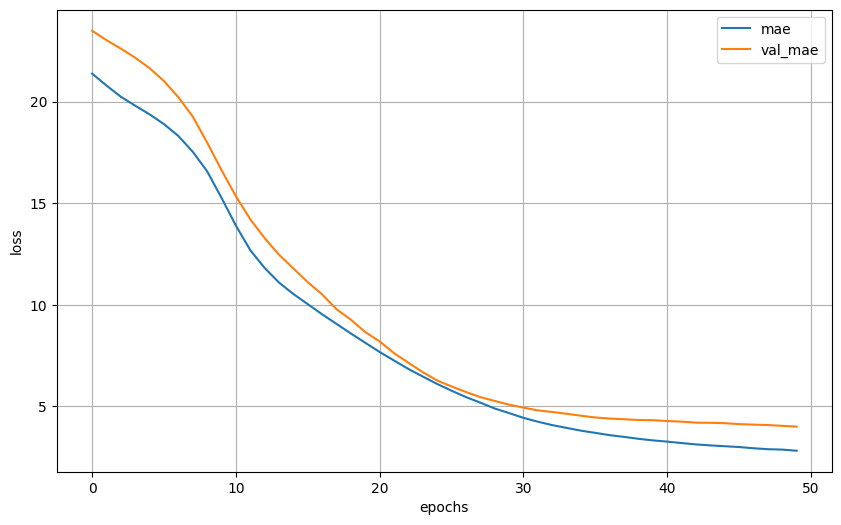

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['mae', 'val_mae']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#### Evaluation

In [18]:
test_loss, test_mae = network.evaluate(X_test_prep, y_test)

2/2 [==============================] - 0s 5ms/step - loss: 16.1040 - mae: 3.1451


In [19]:
print('test_mae:', test_mae)

test_mae: 3.145090103149414


#### Huber loss function

In [20]:
network = models.Sequential()

network.add(layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]))
network.add(layers.Dense(10, activation='relu'))
network.add(layers.Dense(1))

In [21]:
network.compile(
    loss=create_huber(1.0),
    optimizer='adam',
    metrics=['mae']
               )

In [22]:
history = network.fit(X_train_prep,
                      y_train,
                      epochs=50,
                      validation_data=(X_val_prep, y_val))

Epoch 1/50
13/13 [==============================] - 1s 14ms/step - loss: 22.3545 - mae: 22.8545 - val_loss: 24.1847 - val_mae: 24.6847
Epoch 2/50
13/13 [==============================] - 0s 3ms/step - loss: 21.7446 - mae: 22.2446 - val_loss: 23.7017 - val_mae: 24.2017
Epoch 3/50
13/13 [==============================] - 0s 3ms/step - loss: 21.2043 - mae: 21.7043 - val_loss: 23.2376 - val_mae: 23.7376
Epoch 4/50
13/13 [==============================] - 0s 3ms/step - loss: 20.6818 - mae: 21.1810 - val_loss: 22.7557 - val_mae: 23.2557
Epoch 5/50
13/13 [==============================] - 0s 3ms/step - loss: 20.1430 - mae: 20.6428 - val_loss: 22.2097 - val_mae: 22.7016
Epoch 6/50
13/13 [==============================] - 0s 3ms/step - loss: 19.5445 - mae: 20.0432 - val_loss: 21.6820 - val_mae: 22.1807
Epoch 7/50
13/13 [==============================] - 0s 3ms/step - loss: 18.9591 - mae: 19.4561 - val_loss: 21.1686 - val_mae: 21.6686
Epoch 8/50
13/13 [==============================] - 0s 3ms/st

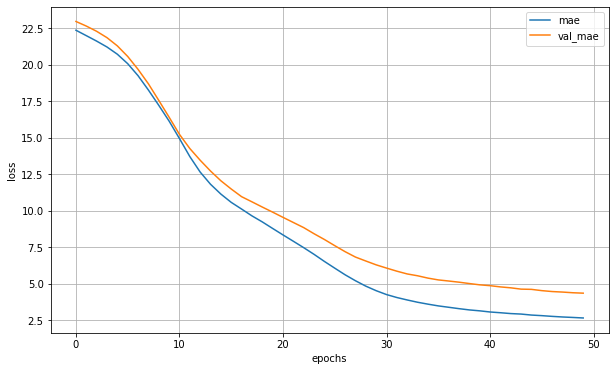

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['mae', 'val_mae']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#### Evaluation

In [ ]:
test_loss, test_mae = network.evaluate(X_test_prep, y_test)

2/2 [==============================] - 0s 955us/step - loss: 1.5974 - mae: 2.0466


In [ ]:
print('test_mae:', test_mae) # the error was reduced with this loss function

test_mae: 2.046584367752075


## Save the personalized model

In [23]:
# Save it on the disk
network.save("modelo_huber_loss.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Import it
network2 = tf.keras.models.load_model("modelo_huber_loss.h5",
                                      custom_objects={"huber_fn": create_huber(1.0)})

In [25]:
history = network2.fit(X_train_prep,
                      y_train,
                      epochs=2,
                      validation_data=(X_val_prep, y_val))

Epoch 1/2
13/13 [==============================] - 0s 14ms/step - loss: 1.9926 - mae: 2.4433 - val_loss: 3.1544 - val_mae: 3.6230
Epoch 2/2
13/13 [==============================] - 0s 3ms/step - loss: 1.9545 - mae: 2.4016 - val_loss: 3.1532 - val_mae: 3.6191
